# Case 1 - 2440062123 - Vika Valencia Susanto
Link video: https://drive.google.com/file/d/1Wh7420ZMw3_8DRN1NGUx1UBTerlNq01P/view?usp=sharing 

Segmentasi gambar merupakan proses membagi gambar digital ke beberapa segmen berdasarkan dengan heat map. Pada case 1 ini, yang akan disegmentasi adalah area perhutanan dari gambar satelit. Hal ini termasuk ke dalam semantic segmentation karena yang akan diamati hanya hutannya saja. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp "/content/drive/MyDrive/Dataset DL/Aerial Image Dataset.zip" ./

In [3]:
!unzip "/content/Aerial Image Dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_73.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_77.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_78.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_80.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_81.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_87.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_88.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_00.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_01.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_03.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_04.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_11.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_m

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
import torch.nn as nn
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout, Layer, Add, Multiply, ReLU,UpSampling2D 
from tensorflow.keras.models import Model

Data akan dibagi menjadi train dan validation dengan ukuran train adalah 80% dan ukuran validation adalah 20% dari total data. Data forest sendiri terdiri dari 2 folder yaitu image (gambar hutan dari satelit) dan masks (gambar segmentasi hutan).

In [2]:
path = '/content/Forest Segmented/Forest Segmented'

image_generator = ImageDataGenerator(rescale=1./255,validation_split=0.2)
mask_generator = ImageDataGenerator(rescale=1./255,validation_split=0.2)

train_image_params = image_generator.flow_from_directory(
        path,
        target_size=(128, 128),
        class_mode = None,
        classes = ['images'],
        batch_size = 16,
        seed = 200,
        subset='training')
    
train_mask_params = mask_generator.flow_from_directory(
        path,
        target_size=(128, 128),
        class_mode = None,
        classes = ['masks'],
        batch_size = 16,
        seed = 200,
        subset='training')

val_image_params = image_generator.flow_from_directory(
        path,
        target_size=(128, 128),
        class_mode = None,
        classes = ['images'],
        batch_size = 16,
        seed = 200,
        subset='validation')
    
val_mask_params = mask_generator.flow_from_directory(
        path,
        target_size=(128, 128),
        class_mode = None,
        classes = ['masks'],
        batch_size = 16,
        seed = 200,
        subset='validation')

train = zip(train_image_params, train_mask_params)
valid = zip(val_image_params, val_mask_params)

Found 4087 images belonging to 1 classes.
Found 4087 images belonging to 1 classes.
Found 1021 images belonging to 1 classes.
Found 1021 images belonging to 1 classes.


Gambar akan diresize dengan ukuran 128 * 128. Dataset diimport menjadi 4 bagian, yaitu image dan mask untuk data train, dan image dan mask untuk data validation. Seed = 200 agar setiap dirun, data acak yang digenerate tidak berubah. Kemudian data akan disatukan ke dalam dataset train dan valid. Setiap batch akan berisi 16 data. Semakin besar batch size, maka semakin tidak akurat hasilnya, namun waktu training akan lebih cepat dikarenakan iterasi yang lebih sedikit.

In [3]:
training_size = train_image_params.samples
val_size = val_image_params.samples
print(training_size, val_size)

4087 1021


Total data training ada 4087 data sedangkan valid terdapat 1021 data.

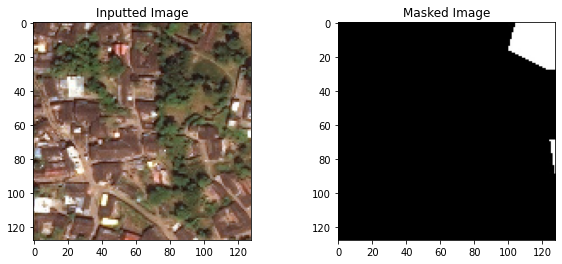

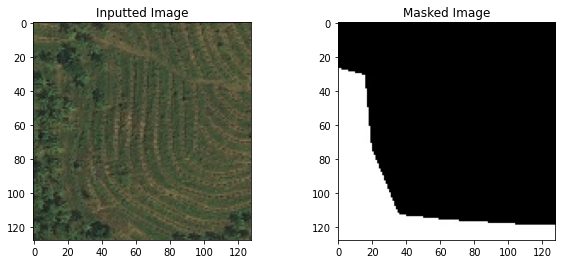

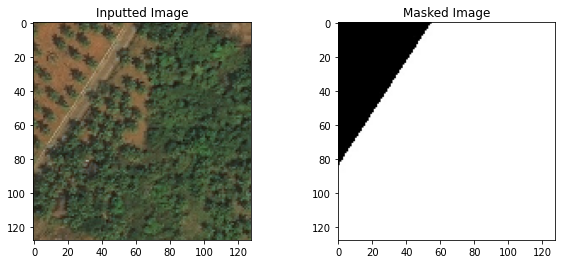

In [4]:
n = 0
for i,m in train:
    mask, image = m,i
    if n < 3:
        fig, axs = plt.subplots(1 , 2, figsize=(10,4))
        axs[0].imshow(image[0])
        axs[0].set_title('Inputted Image')
        axs[1].imshow(mask[0],cmap='gray')
        axs[1].set_title('Masked Image')
        plt.show()
        n = n + 1
    else:
        break

Jika dilihat dari gambar di atas, daerah hutan diwarnai dengan warna yang lebih terang.

In [5]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


class AttentionGate(Layer):
    def __init__(self, filters, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)
        self.filters = filters
        
        self.C1 = Conv2D(filters, kernel_size=1, strides=1, padding='same', activation=None)
        self.C2 = Conv2D(filters, kernel_size=1, strides=2, padding='same', activation=None)
        self.relu = ReLU()
        self.add = Add()
        self.C3 = Conv2D(1,kernel_size=1, strides=1, padding='same', activation='sigmoid')
        self.up = UpSampling2D()
        self.mul = Multiply()
        self.BN = BatchNormalization()
                
    def call(self, X):
        org_x, skip_g = X
        g = self.C1(org_x)
        x = self.C2(skip_g)
        x = self.add([g,x])
        x = self.C3(x)
        x = self.up(x)
        x = self.mul([x,skip_g])
        x = self.BN(x)
        return x
    
    def get_config(self):
        base_config = super().get_config()
        base_config.update({
            "filters":self.filters
        })
        return base_config


def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)

    b1 = conv_block(p3, 256)

    d1 = decoder_block(b1, s3, 128)
    d2 = decoder_block(d1, s2, 64)
    d3 = decoder_block(d2, s1, 32)


    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    model = Model(inputs, outputs, name="U-Net")
    return model

def build_att_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)

    b1 = conv_block(p3, 256)

    a1 = AttentionGate(128)([b1, s3])
    d1 = decoder_block(b1, a1, 128)
    a2 = AttentionGate(64)([d1, s2])
    d2 = decoder_block(d1, a2, 64)
    a3 = AttentionGate(32)([d2, s1])
    d3 = decoder_block(d2, a3, 32)


    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    model = Model(inputs, outputs, name="Attention-U-Net")
    return model

Arsitektur yang digunakan adalah arsitektur U-net yang memiliki encoder dan decoder (https://arxiv.org/pdf/1505.04597.pdf). Model ini menggunakan filter convolutional untuk mendeteksi fitur pada gambar dan diterapkan transpose pada gambar bersambung dengan beberapa fitur di bagian encoder. Model ini dipilih karen UNet menggunakan fitur yang sama yang digunakan untuk mengexpand vektor ke gambar yang sudah disegmentasi sehingga akan mengurangi distorsi pada gambar, sehingga gambar yang dihasilkan dari vektor akan lebih merepresentasikan gambar awalnya.

- Encoder (mereduksi resolusi spasial(downsampling)/merubah state menjadi vektor): berisi pengulangan aplikasi dari dua konvolusi 3x3. Setiap konvolusi diikuti dengan ReLU activation function dan maxpool 2x2 dengan stride 2 untuk downsampling. Pada setiap step, filter akan dilipatgandakan sebanyak 2 kali dari filter sebelumnya
- Decoder (meningkatkan resolusi spasial (upsampling)/merubah vektor menjadi state): berisi upsampling dari peta dengan 2x2 transpos konvolusi dan disambungkan dengan dua konvolusi 3x3 yang diikuti dengan ReLU untuk setiap konvolusinya.
- Di layer terakhir ada konvolusi 1x1 yang digunakan untuk menyatakan setiap komponen dan segmentasi ke gambar 1 dimensi atau grayscale.

Perubahan dari arsitektur awal:
- Padding dari setiap konvolusi disamakan dengan model
- Terdapat perubahan dari blok layer konvolusi pada encoder dan decoder, di mana filter dimulai dari 32 filter. Sedangkan dari model asli, dimulai dari 64 filter.

Note: attention merupakan cara untuk menghighlight aktivasi yang relevan saat training. Attention mengurangi sumber daya komputasional yang sia sia karena ada aktivasi yang tidak relevan sehingga network bisa mengeneralisasi dengan lebih baik. Ada dua tipe attention yaitu hard attention(menghighlight bagian relevan dengan memotong gambar dan haya bisa memilih satu region pada gambar pada satu waktu yang artinya network hanya bisa memperhatikan atau tidak memperhatikan. Hal ini menyebabkan backpropagation biasa tidak bisa dilakukan) dan soft attention (dengan memberikan weight dari setiap bagian gambar yang berbeda. Laye yang relevan weightnya akan lebih besar. Saat training, akan difokuskan pada weight yang lebih besar. Weight ini bisa diaplikasikan ke banyak bagian gambar)
- Penambahan soft attention yaitu AttentionGate untuk setiap skip-connection (sebelum decoder) karena soft-attention dapat diaplikasikan ke banyak bagian gambar dan parameter AG bisa ditrain dengan back-propagation standar tanpa membutuhkan metode optimisasi sampling seperti hard-attention (https://www.researchgate.net/publication/330877339_Attention_Gated_Networks_Learning_to_Leverage_Salient_Regions_in_Medical_Images): 
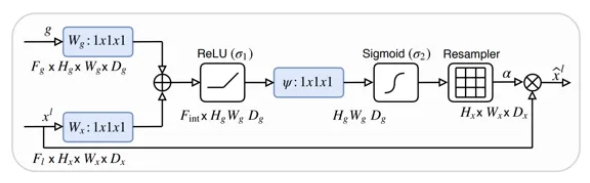
1. attention gate memiliki 2 input vektor yaitu g(diambil dari layer terkecil selanjutnya di network) dan x(layer yang lebih besar dari g).
2. x akan masuk ke strided konvolusi, misal awalnya (64x64x64), akan jadi (64x32x32).
3. kedua vektor akan dijumlahkan untuk menghasilkan weight
4. vektor hasil akan masuk ke ReLU activation dan 1x1 konvolusi yang akan mengubah dimensinya ke 1x32x32
5. vektornya akan lanjut ke sigmoid layer (output: [0,1]) menghasilkan weight dengan weight mendekati 1 artinya fiturnya lebih relevan
6. koefisien attention/weight dikalikan dengan vektor x original dan akan dipas ke skip-connection sebagai normal.

Link: https://towardsdatascience.com/a-detailed-explanation-of-the-attention-u-net-b371a5590831

In [6]:
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    union = area_true + area_pred - intersection

    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    iou = intersection / union

    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1  # dideteksi positif dan memang positif
        false_positives = np.sum(matches, axis=0) == 0  # dideteksi positif tapi aslinya negatif
        false_negatives = np.sum(matches, axis=1) == 0  # dideteksi negatif tapi aslinya positif
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.compat.v1.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

Matriks yang digunakan pada segmentasi gambar ini adalah matriks intersection over union atau Jaccard index untuk menghitung persentase overlap antara mask prediksi dan mask target.

Referensi: https://www.codeastar.com/u-net-object-detection-iou/ 

In [7]:
model = build_unet((128, 128, 3))
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.0001), loss = ['binary_crossentropy'], metrics=[iou_coef,'accuracy'])
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 batch_normalization_8 (BatchNo  (None, 32, 32, 128)  512        ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 32, 32, 128)  0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 32, 32, 128)  147584      ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 32, 32, 128)  512        ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activatio

Training dilakukan dengan loss function binary cross entropy karena outpunya binary yaitu 1 dan 0 (dari function sigmoid dan relu). Kemudian untuk optimizer digunakan Adam dengan learning rate 0.0001. Model dibuat dengan inputnya tadi adalah 128*128 dengan dimensi 3.

In [8]:
model_path = "unet.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

Saat training, model diberikan checkpoint dengan mencari model dengan validation loss terkecil. Kemudian juga diterapkan early stopping agar training bisa berhenti jika update parameter tidak menurunkan loss lagi selama 5 (patience = 5)kali berturut-turut. 

In [9]:
history = model.fit(train, #data train
                    steps_per_epoch=training_size//16,
                    validation_data=valid, #data validation
                    validation_steps=val_size//16,
                    epochs=30, callbacks=[earlystop, checkpoint])

Epoch 1/30
255/255 [==============================] - ETA: 0s - loss: 0.5116 - iou_coef: 1.1709 - accuracy: 0.7545
Epoch 1: val_loss improved from inf to 2.90736, saving model to unet.h5
255/255 [==============================] - 38s 115ms/step - loss: 0.5116 - iou_coef: 1.1709 - accuracy: 0.7545 - val_loss: 2.9074 - val_iou_coef: 0.0301 - val_accuracy: 0.3782
Epoch 2/30
255/255 [==============================] - ETA: 0s - loss: 0.4672 - iou_coef: 1.2173 - accuracy: 0.7802
Epoch 2: val_loss improved from 2.90736 to 0.61638, saving model to unet.h5
255/255 [==============================] - 24s 95ms/step - loss: 0.4672 - iou_coef: 1.2173 - accuracy: 0.7802 - val_loss: 0.6164 - val_iou_coef: 0.8455 - val_accuracy: 0.7148
Epoch 3/30
255/255 [==============================] - ETA: 0s - loss: 0.4532 - iou_coef: 1.2376 - accuracy: 0.7886
Epoch 3: val_loss improved from 0.61638 to 0.45985, saving model to unet.h5
255/255 [==============================] - 24s 94ms/step - loss: 0.4532 - iou_co

Untuk 30 epoch dengan total training 11 epoch, bisa dilihat bahwa loss semakin berkurang. Traning diearlystop karena pada 5 epoch terakhir loss tidak menurun. Loss sendiri merupakan kemampuan model untuk meyakinkan bahwa dirinya sendiri benar. Semakin kecil loss maka semakin baik model. Akurasi model pada training juga meningkat dengan nilai maks 82%, sehingga artinya training berhasil dalam menghasilkan model yang lebih baik.

In [10]:
random_val_samples = valid.__next__()
val_image_sample = random_val_samples[0]
val_mask_sample = random_val_samples[1]
predicted = model.predict(val_image_sample)

1/1 [==============================] - 0s 289ms/step


U-Net



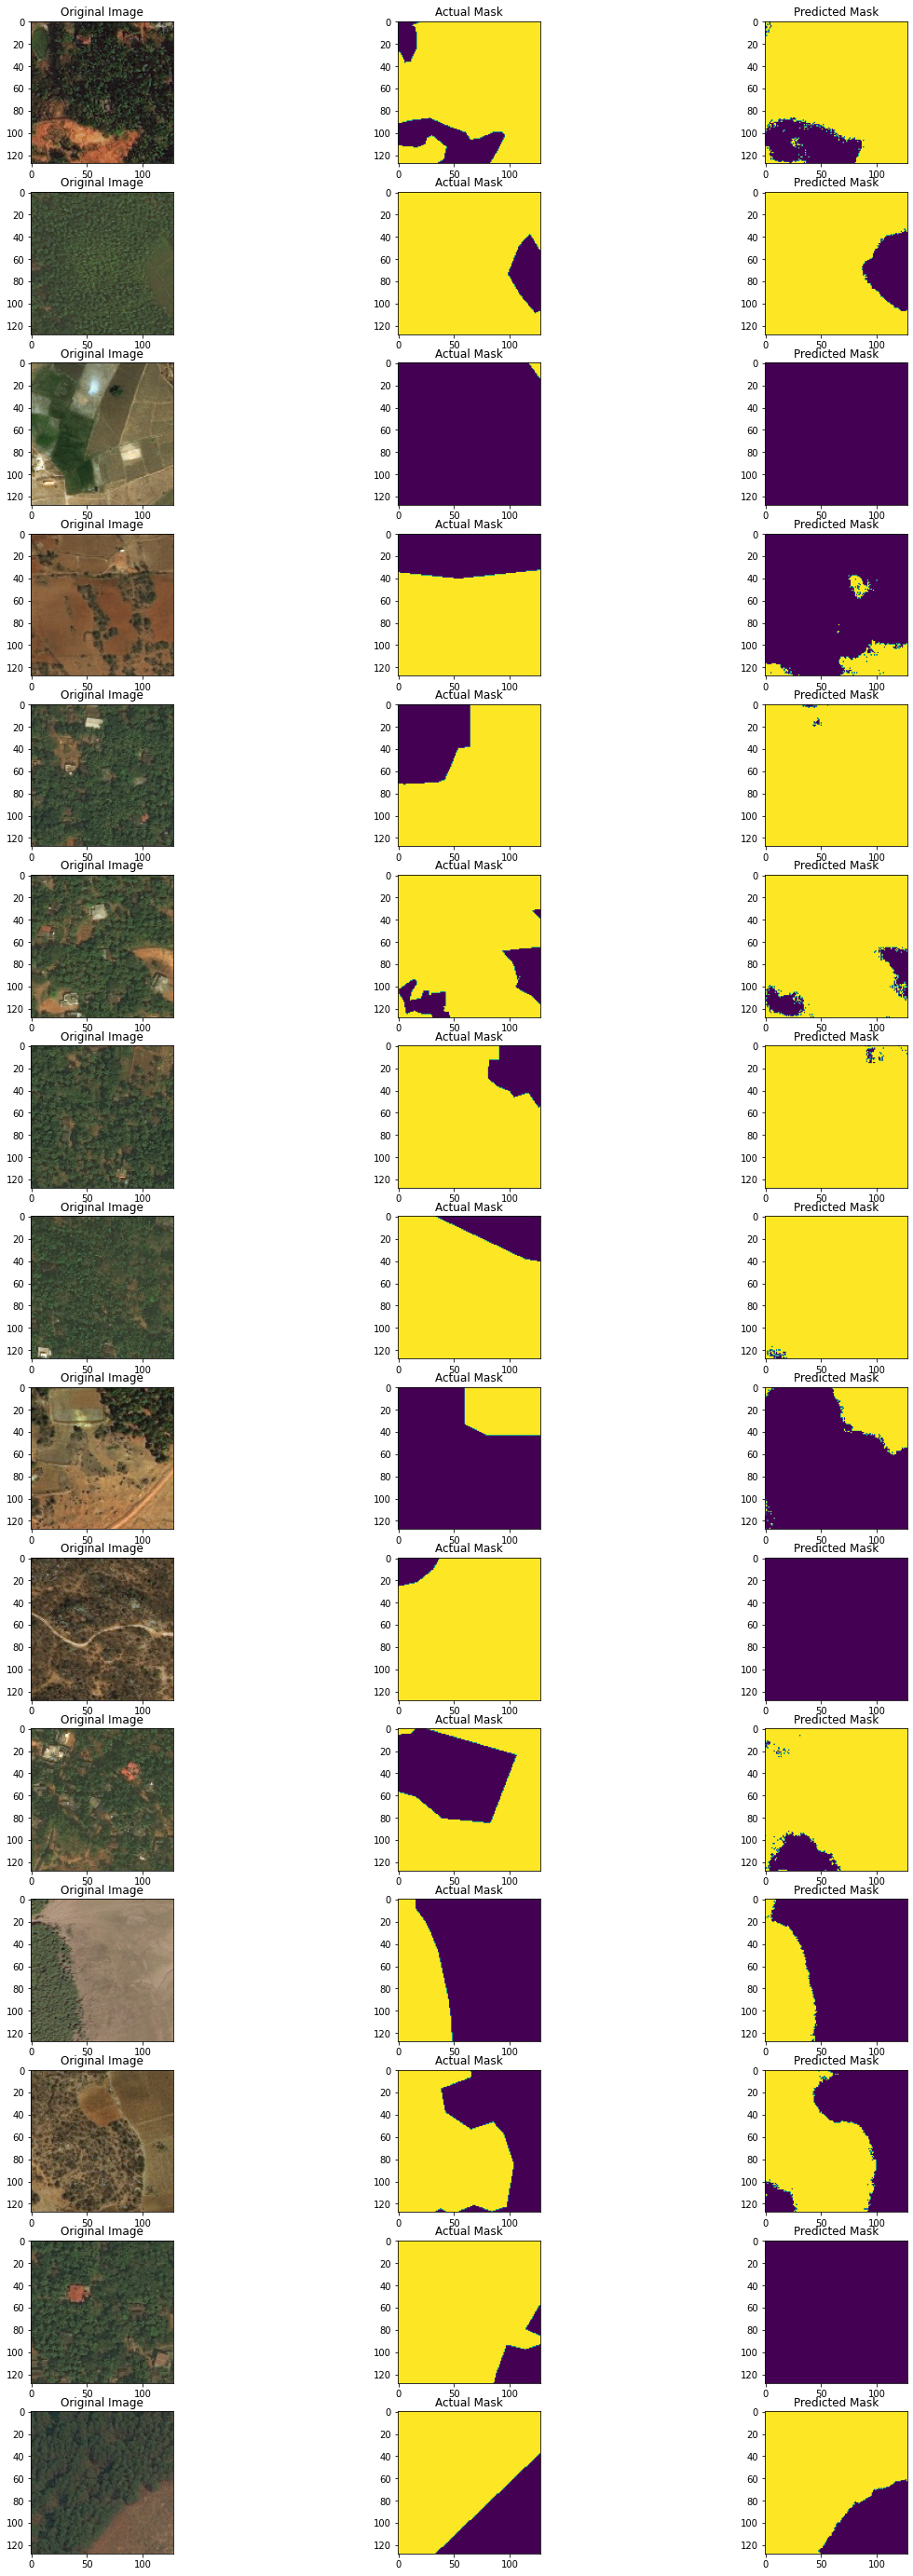

In [11]:
f, axarr = plt.subplots(15, 3,figsize=(20, 50))
predicted[predicted >= 0.5] = 1
predicted[predicted < 0.5] = 0
print("U-Net\n")

for i in range(0,15):

    axarr[i,0].imshow(val_image_sample[i])
    axarr[i,0].title.set_text('Original Image')
    axarr[i,1].imshow(val_mask_sample[i][:,:,0])
    axarr[i,1].title.set_text('Actual Mask')
    axarr[i,2].imshow(predicted[i][:,:,0])
    axarr[i,2].title.set_text('Predicted Mask')

Beberapa gambar tidak seperti dengan mask aslinya, namun itu mungkin dikarenakan kesalahan saat data preparation. Namun berdasarkan beberapa perbandingan, model yang dibuat melakukan prediksi dengan hasil yang cukup buruk seperti contohnya pada gambar ke 14 atau yang lain-lain. Bagian hutan diberikan dengan warna yang lebih terang yaitu kuning. Akurasi yang didapatkan saat training untuk train dan validation adalah 82%, menunjukkan bahwa model bisa melakukan segmentasi secara benar 82%. 

In [12]:
model_att = build_att_unet((128, 128, 3))
model_att.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.0001), loss = ['binary_crossentropy'], metrics=[iou_coef,'accuracy'])
model_att.summary()

Model: "Attention-U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_14 (BatchN  (None, 128, 128, 32  128        ['conv2d_15[0][0]']              
 ormalization)                  )                                                   

Buat model U-net yang menggunakan attention. Untuk optimizer, loss, dan metrics sama dengan model U-net yang biasa. Namun disini diberikan checkpoint baru untuk model tersebut.

In [13]:
model_path_att = "att-unet.h5"
checkpoint_att = ModelCheckpoint(model_path_att,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1) #buat checkpoint baru untuk model dengan attention

In [14]:
history2 = model_att.fit(train, #data train
                    steps_per_epoch=training_size//16,
                    validation_data=valid, #data validation
                    validation_steps=val_size//16,
                    epochs=30, callbacks=[earlystop, checkpoint_att])

Epoch 1/30
255/255 [==============================] - ETA: 0s - loss: 0.5168 - iou_coef: 1.0877 - accuracy: 0.7527
Epoch 1: val_loss improved from inf to 2.66931, saving model to att-unet.h5
255/255 [==============================] - 33s 119ms/step - loss: 0.5168 - iou_coef: 1.0877 - accuracy: 0.7527 - val_loss: 2.6693 - val_iou_coef: 0.0274 - val_accuracy: 0.3815
Epoch 2/30
255/255 [==============================] - ETA: 0s - loss: 0.4665 - iou_coef: 1.1969 - accuracy: 0.7828
Epoch 2: val_loss improved from 2.66931 to 1.03280, saving model to att-unet.h5
255/255 [==============================] - 29s 115ms/step - loss: 0.4665 - iou_coef: 1.1969 - accuracy: 0.7828 - val_loss: 1.0328 - val_iou_coef: 0.3989 - val_accuracy: 0.5345
Epoch 3/30
255/255 [==============================] - ETA: 0s - loss: 0.4494 - iou_coef: 1.2360 - accuracy: 0.7898
Epoch 3: val_loss improved from 1.03280 to 0.42972, saving model to att-unet.h5
255/255 [==============================] - 28s 110ms/step - loss: 0

Training dilakukan kembali untuk model unet dengan attention. Epoch di earlystop pada epoch ke 13 dengan akurasi 82.80%. Loss yang semakin berkurang menandakan bahwa traning berhasil menghasilkan model yang lebih baik.

In [15]:
predicted_att = model_att.predict(val_image_sample)

1/1 [==============================] - 0s 356ms/step


Attention U-Net



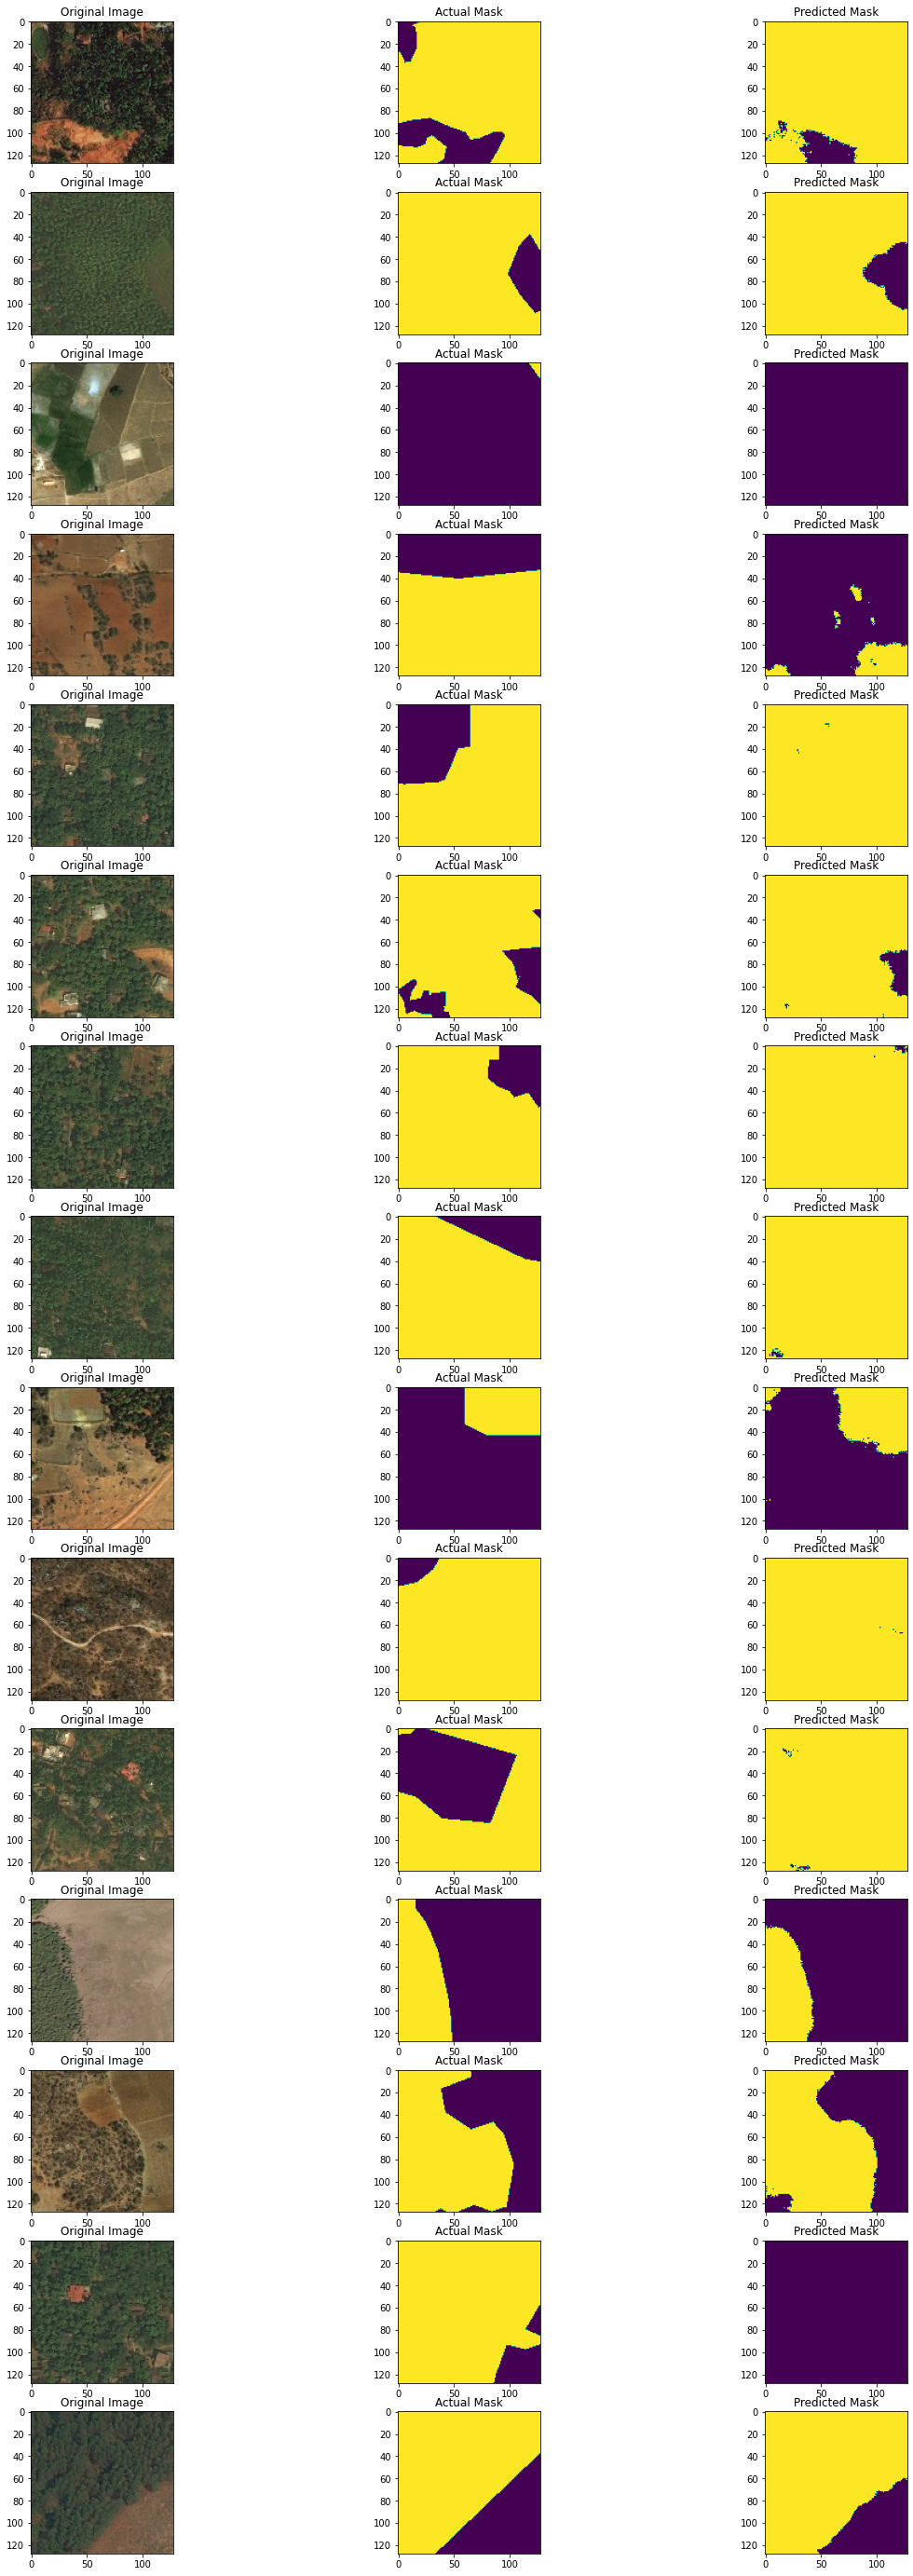

In [16]:
f, axarr = plt.subplots(15, 3,figsize=(20, 50))
predicted_att[predicted_att >= 0.5] = 1
predicted_att[predicted_att < 0.5] = 0

print("Attention U-Net\n")

for i in range(0,15):
    axarr[i,0].imshow(val_image_sample[i])
    axarr[i,0].title.set_text('Original Image')
    axarr[i,1].imshow(val_mask_sample[i][:,:,0])
    axarr[i,1].title.set_text('Actual Mask')
    axarr[i,2].imshow(predicted_att[i][:,:,0])
    axarr[i,2].title.set_text('Predicted Mask')

Dengan menggunakan sampel yang sama, model attention unet dilakukan untuk memprediksi. Model u-net dengan attention melakukan segmentasi dengan hasil yang tidak jauh berbeda, dengan akurasi 82% juga.

Comparison



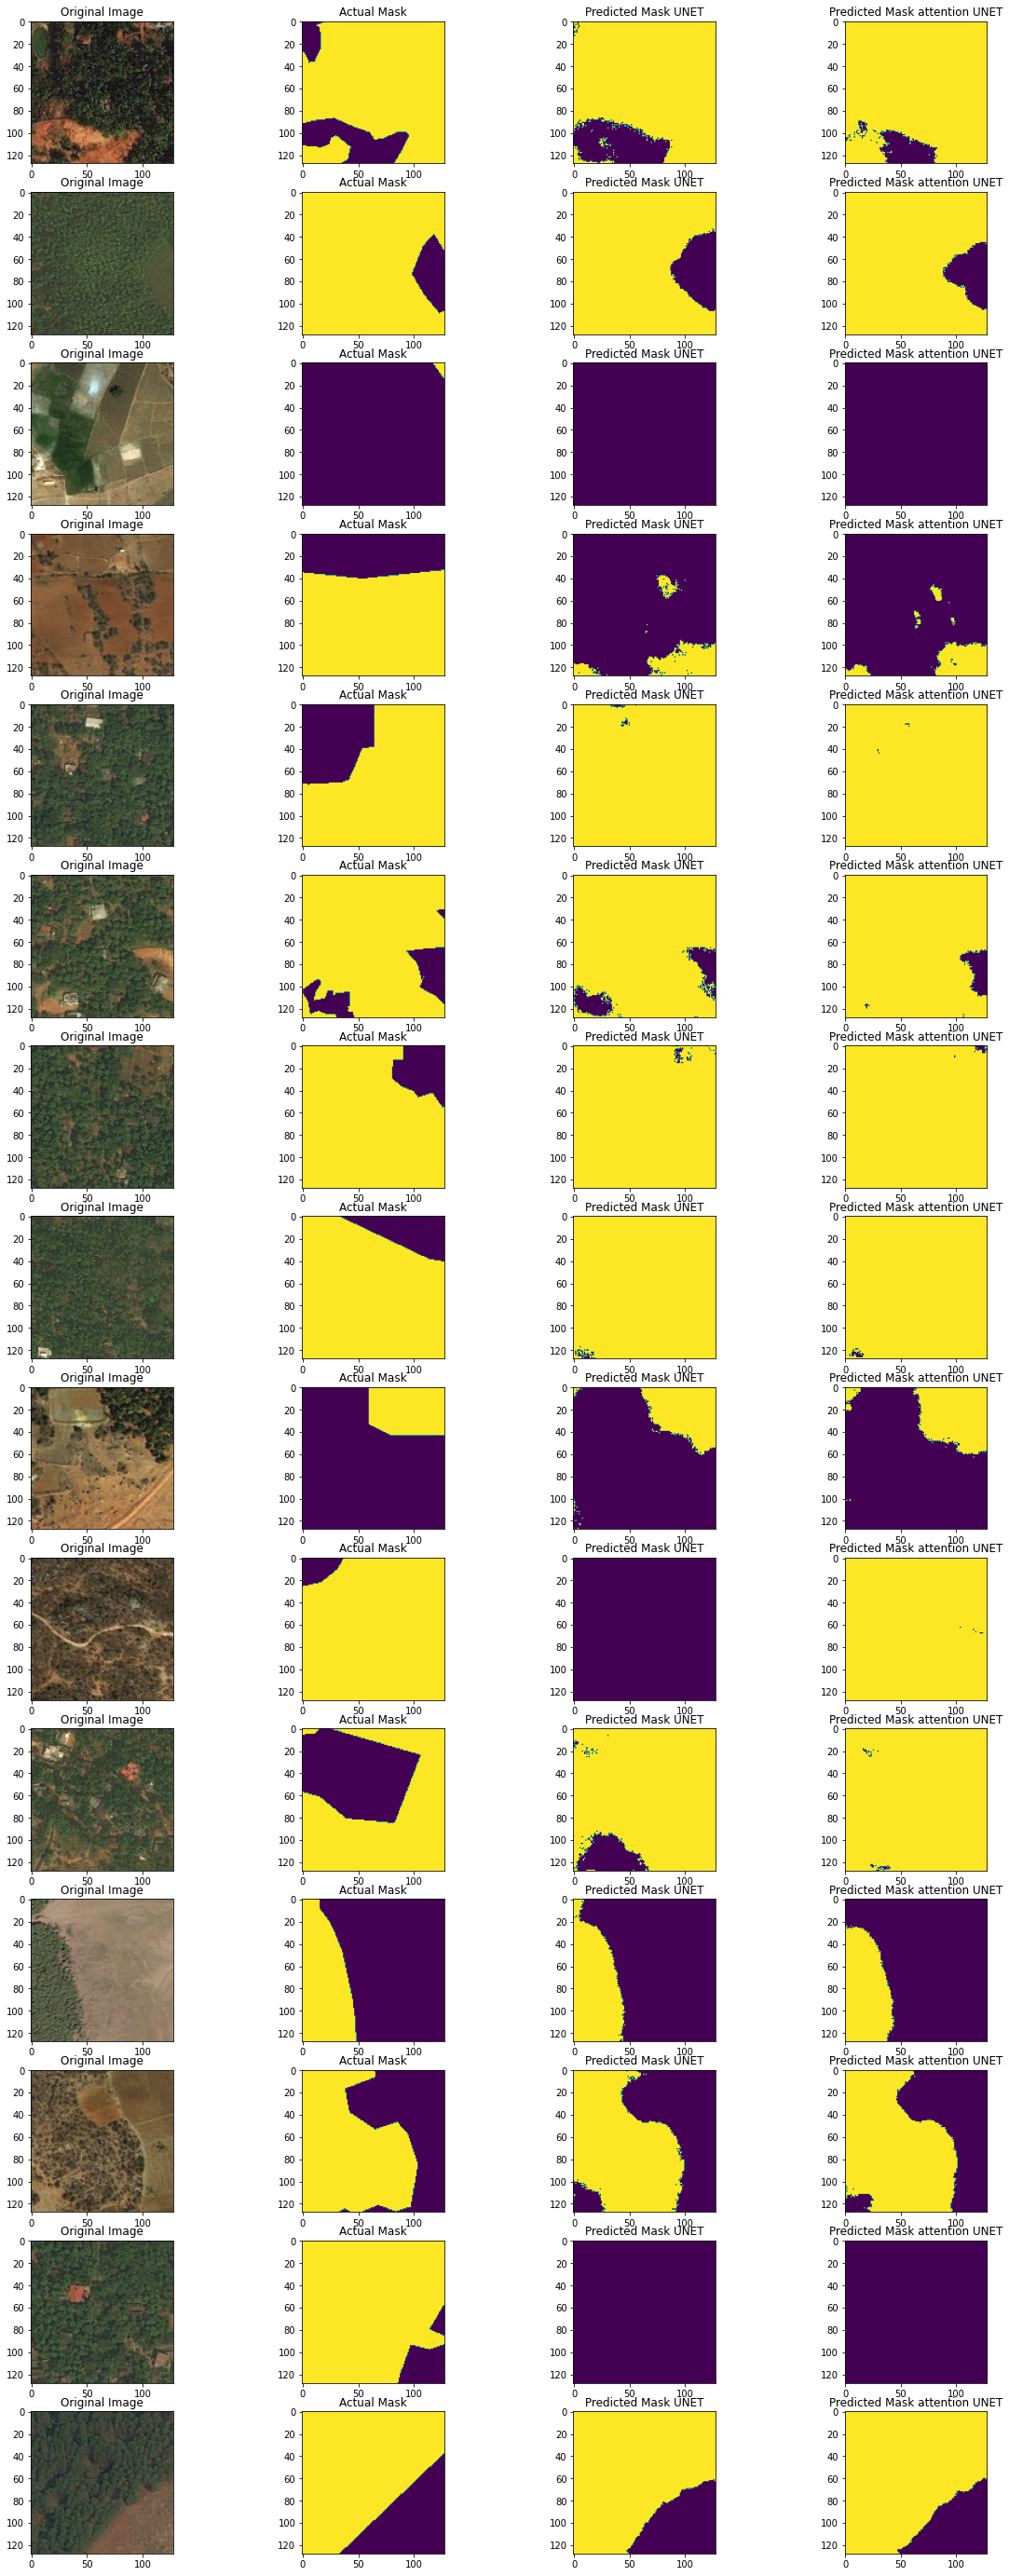

In [17]:
f, axarr = plt.subplots(15, 4,figsize=(20, 50))

print("Comparison\n")

for i in range(0,15):
    axarr[i,0].imshow(val_image_sample[i])
    axarr[i,0].title.set_text('Original Image')
    axarr[i,1].imshow(val_mask_sample[i][:,:,0])
    axarr[i,1].title.set_text('Actual Mask')
    axarr[i,2].imshow(predicted[i][:,:,0])
    axarr[i,2].title.set_text('Predicted Mask UNET')
    axarr[i,3].imshow(predicted_att[i][:,:,0])
    axarr[i,3].title.set_text('Predicted Mask attention UNET')


Dengan melihat perbandingan hasil segmentasi side to side, bisa dilihat bahwa hasil segmentasi dari kedua model tidak memberikan hasil yang jauh berbeda. Namun di gambar ke-10 dilihat bahwa model u-net dengan attention memberikan hasil segmentasi yang lebih signifikan. Hal ini dikarenakan soft attention memberikan weight kepada setiap bagian sehingga model bisa lebih fokus kepada weight yang lebih besar. Meskipun demikian, untuk kedepannya akan dicoba metode lain untuk segmentasi gambar dengan menggunakan model, attention, matriks, atau parameter lainnya.